In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import get_hidden, get_force, get_data
import numpy as np
import torch as th
import plot as plot
import matplotlib.pyplot as plt
import pandas as pd
from tdr import gsog
import seaborn as sb
import scipy.stats as stats

In [5]:
# Load hidden
folder_name = 'Sim_all'
results = pd.DataFrame()

for mn in range(0,20): # range(0,20) # [8]
    model_name = "model{:02d}".format(mn)

    #data = get_hidden(folder_name,model_name,phase,ff_coef,demean=False)
    #model_name = 'model00'

    # find the perturbation direction
    data = get_hidden(folder_name,model_name,{'NF1':[0],'FF1':[8]},[0,8],demean=False)
    force = get_force(folder_name,model_name,{'NF1':[0],'FF1':[8]},[0,8])

    N_idx = 16
    F_idx = 25 # index of force
    for i in range(len(data)):
        data[i] = data[i][:,N_idx,:]
        force[i] = force[i][:,F_idx,:]

    # remove overall mean
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)

    for i in range(len(data)):
        data[i] = data[i]-mean_N

    # use NF1 to project onto TDR axes
    X = force[0] # NF1 force 
    N = data[0] # NF1 hidden activity

    X = np.hstack((X,np.ones((X.shape[0],1))))
    beta_b2n = np.linalg.pinv(X) @ N

    # Compute the TDR axes.
    beta_n2b = np.linalg.pinv(beta_b2n)
    beta_n2b = beta_n2b[:,:2]

    # Orthogonalize the TDR axes before projection.
    beta_n2b_orth = gsog(beta_n2b)[0]

    # uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0)
    us = us.reshape(-1,1)
    us_orth = us - np.dot(beta_n2b_orth[:,0],us)/np.linalg.norm(beta_n2b_orth[:,0])**2 * beta_n2b_orth[:,0][:,None]
    us_orth = us_orth - np.dot(beta_n2b_orth[:,1],us_orth)/np.linalg.norm(beta_n2b_orth[:,1])**2 * beta_n2b_orth[:,1][:,None]
    us_orth_norm = us_orth/np.linalg.norm(us_orth)

    t_disturb_hidden=N_idx/100
    d_hidden = th.from_numpy(us_orth_norm.T*0.6)

    # now lets perturb or not and calculate the saving in behavior
    data_p, loss_p = get_data(folder_name,model_name,{'NF2':[0]},[8],is_channel=False,
                              disturb_hidden=True,t_disturb_hidden=t_disturb_hidden,d_hidden=d_hidden,return_loss=True)

    data_np, loss_np = get_data(folder_name,model_name,{'NF1':[0],'NF2':[0]},[8,8],is_channel=False,
                                disturb_hidden=False,t_disturb_hidden=t_disturb_hidden,d_hidden=d_hidden,return_loss=True)
    
    # plot
    # n_fig = 1
    # fig,ax = plt.subplots(1,n_fig,figsize=(7*n_fig,5))
    # ax = [ax]

    # plot.plot_simulations(ax[0],xy=data_np[1]['xy'],target_xy=data_np[1]['tg'],vel=None,plot_lat=False)
    # plot.plot_simulations(ax[0],xy=data_p[0]['xy'],target_xy=data_p[0]['tg'],vel=None,plot_lat=False,cmap='plasma')

    # fig, ax = plot.plot_activation(data_p[0]['all_hidden'],data_p[0]['all_muscle']-data_np[1]['all_muscle'],figsize=(15,15))

    loss_type = 'angle'
    loss_ff1 = loss_np[0][loss_type].item()
    loss_ff2_np = loss_np[1][loss_type].item()
    loss_ff2_p = loss_p[0][loss_type].item()

    d = {'m':[mn]*3,'loss':[loss_ff1,loss_ff2_np,loss_ff2_p],'phase':['ff1','ff2','ff2_p']}
    results = pd.concat([results,pd.DataFrame(d)],ignore_index=True)

T-statistic: 2.496984328025669
P-value: 0.021879033014672134


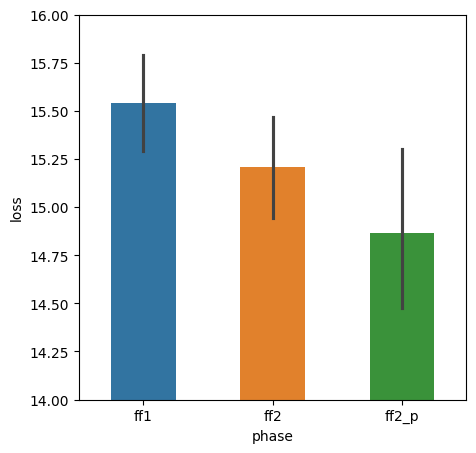

In [6]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax = sb.barplot(x='phase',y='loss',data=results,hue='phase',width=0.5)

#ax.set_ylim([33,38])
#ax.set_ylim([0.03,0.035])
ax.set_ylim([14,16])

T = results.pivot_table(index='m',columns='phase',values='loss')
t_statistic, p_value = stats.ttest_rel(T['ff2'],T['ff2_p'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

In [20]:
t_statistic, p_value = stats.ttest_rel(T['ff2'],T['ff2_p'])

In [38]:
t_statistic, p_value = stats.ttest_rel(T['ff1'],T['ff2'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.927251732376347
P-value: 0.3654257640171489
